In [1535]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
import pandas as pd
import seaborn as sn
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import KFold   # sklearn k-fold cross-validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn import neighbors, linear_model
from sklearn.pipeline import Pipeline #  apply a series of data transformations followed by the application of an estimator
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings('ignore')

# DATA Retrieval

In [1536]:
df = pd.read_excel('MOOC34_Clean 10-2-22.xlsx', usecols="A, AW, BE:BM, BP, DO, IC, IE:IG")
df.columns

Index(['ID', 'Επίδοση_Α1', 'STARTED', 'DROPOUT', 'Φύλο', 'Ηλικία',
       'Απασχόληση', 'Σπουδές', 'Εμπειρία_MOOC', 'Εμπειρία_ προγρ',
       'Εμπειρία_ Python', 'Πρόθεση_συμμ', 'SRL START num', 'Outro SRL',
       'SRL START categ', 'Cluster (AFTER)', 'Subgroup'],
      dtype='object')

## DATA Exploration

In [1537]:
df.info()  # Επίδοη_Α1: Άσκηση 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4386 entries, 0 to 4385
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                3241 non-null   object 
 1   Επίδοση_Α1        1418 non-null   float64
 2   STARTED           2406 non-null   float64
 3   DROPOUT           1979 non-null   float64
 4   Φύλο              2264 non-null   object 
 5   Ηλικία            2264 non-null   float64
 6   Απασχόληση        2264 non-null   float64
 7   Σπουδές           2264 non-null   object 
 8   Εμπειρία_MOOC     2264 non-null   float64
 9   Εμπειρία_ προγρ   2264 non-null   float64
 10  Εμπειρία_ Python  2264 non-null   float64
 11  Πρόθεση_συμμ      2264 non-null   float64
 12  SRL START num     2262 non-null   float64
 13  Outro SRL         1225 non-null   float64
 14  SRL START categ   2262 non-null   float64
 15  Cluster (AFTER)   1225 non-null   float64
 16  Subgroup          1872 non-null   float64


## DATA preprocessing and cleaning

In [1538]:
df=df.dropna(subset=['SRL START num','STARTED'])   #Keep only 'Started' learners who answered Intro SRL questionnaire
df.shape  

(1990, 17)

In [1539]:
df=df.loc[df['Subgroup'] == 1]  #Keep the control group (baseline)
df.shape

(1564, 17)

In [1540]:
df.head()

,ID,Επίδοση_Α1,STARTED,DROPOUT,Φύλο,Ηλικία,Απασχόληση,Σπουδές,Εμπειρία_MOOC,Εμπειρία_ προγρ,Εμπειρία_ Python,Πρόθεση_συμμ,SRL START num,Outro SRL,SRL START categ,Cluster (AFTER),Subgroup
0,MOOC3_St1,10.0,1.0,1.0,2,5.0,1.0,3,2.0,3.0,1.0,3.0,4.560069,NaN,2.0,NaN,1.0
1,MOOC3_St2,NaN,1.0,1.0,2,4.0,1.0,3,2.0,2.0,2.0,1.0,4.056845,NaN,2.0,NaN,1.0
4,MOOC3_St5,10.0,1.0,NaN,2,5.0,1.0,2,3.0,3.0,2.0,4.0,4.663343,3.462642,2.0,1.0,1.0
6,MOOC3_St7,NaN,1.0,1.0,2,3.0,2.0,5,2.0,2.0,1.0,1.0,5.872520,NaN,3.0,NaN,1.0
7,MOOC3_St8,7.0,1.0,1.0,2,5.0,1.0,3,1.0,2.0,2.0,1.0,5.270238,NaN,3.0,NaN,1.0


In [1541]:
df.isnull().sum()   # check for missing values in variables

ID                    0
Επίδοση_Α1          495
STARTED               0
DROPOUT             957
Φύλο                  0
Ηλικία                0
Απασχόληση            0
Σπουδές               0
Εμπειρία_MOOC         0
Εμπειρία_ προγρ       0
Εμπειρία_ Python      0
Πρόθεση_συμμ          0
SRL START num         0
Outro SRL           627
SRL START categ       0
Cluster (AFTER)     627
Subgroup              0
dtype: int64

In [1542]:
# view frequency counts of categorical variables levels
# https://www.kaggle.com/prashant111/naive-bayes-classifier-in-python 
# Check for cardinality in categorical variables. The number of labels within a categorical variable is known as cardinality. 
# High cardinality may pose some serious problems in the machine learning model.
for var in [   
       'STARTED', 'DROPOUT', 'Φύλο',
       'Ηλικία', 'Απασχόληση', 'Σπουδές',
       'Εμπειρία_MOOC',
       'Εμπειρία_ προγρ',
       'Εμπειρία_ Python',
       'Πρόθεση_συμμ',
        'SRL START categ', 'Cluster (AFTER)',
       'Subgroup', 'Επίδοση_Α1']: 
    print(var, ' contains ', len(df[var].unique()), ' labels')    # ΣΥΧΝΟΤΗΤΑ κάθε τιμής κατηγορικής μεταβλητής
    print(df[var].unique())

STARTED  contains  1  labels
[1.]
DROPOUT  contains  2  labels
[ 1. nan]
Φύλο  contains  5  labels
[2 1 '1, 1' '2, 2' 0]
Ηλικία  contains  6  labels
[5. 4. 3. 2. 1. 6.]
Απασχόληση  contains  3  labels
[1. 2. 0.]
Σπουδές  contains  13  labels
[3 2 5 1 7 4 0 '6, 6' 6 '5, 5' '3, 3' 8 '2, 2']
Εμπειρία_MOOC  contains  4  labels
[2. 3. 1. 0.]
Εμπειρία_ προγρ  contains  5  labels
[3. 2. 1. 4. 0.]
Εμπειρία_ Python  contains  5  labels
[1. 2. 3. 4. 0.]
Πρόθεση_συμμ  contains  8  labels
[3. 1. 4. 6. 2. 0. 5. 7.]
SRL START categ  contains  4  labels
[2. 3. 1. 4.]
Cluster (AFTER)  contains  5  labels
[nan  1.  3.  2.  4.]
Subgroup  contains  1  labels
[1.]
Επίδοση_Α1  contains  10  labels
[10. nan  7.  8.  5.  6.  9.  4.  3.  1.]


In [1543]:
df['DROPOUT'] = df['DROPOUT'].fillna(0)  # Replace DROPOUT Nan with 0
df.shape  # view dimensions of dataset

(1564, 17)

In [1544]:
df = df.loc[(df['Φύλο'] != 0.0)]  #Remove rows where Gender='0.0'
df = df.loc[(df['Απασχόληση'] != 0.0)]   
df = df.loc[(df['Σπουδές'] != 0.0)]  
df = df.loc[(df['Εμπειρία_MOOC'] != 0.0)]
df = df.loc[(df['Πρόθεση_συμμ'] != 0.0)]

df['Σπουδές'].unique()
df.shape

(1543, 17)

In [1545]:
# correction of Educ levels (contain values like '6,  6'  -> must be transformed to 6.0)
Educ_array=df['Σπουδές'].to_numpy()
Gender_array=df['Φύλο'].to_numpy()
j=0
for i in Educ_array:  
    if ',' in str(i):
        Educ_array[j]=str(float(df.iat[j,7][0])) #Education is the 8th column
    Educ_array[j]=float(Educ_array[j])   #Educ_array must be of type float
    j+=1   
#np.unique(Educ_array)  # check labels in Educ variable
j=0
for k in Gender_array:  # correction of Educ levels (contain values like '6,  6'  -> must be transformed to 6.0)
    if ',' in str(k):
        Gender_array[j]=str(float(df.iat[j,4][0]))   #Gender is the 5th column
    Gender_array[j]=float(Gender_array[j])   #Gender_array must be of type float
    j+=1   
#np.unique(Gender_array)  # check labels in Gender variable

In [1546]:
MOOC3=df[df.ID<'MOOC4'] 
MOOC4=df[df.ID>='MOOC4'] 
print("MOOC3 shape: {}".format(MOOC3.shape))   # view dimensions of dataset
print("MOOC4 shape: {}".format(MOOC4.shape))

MOOC3 shape: (1324, 17)
MOOC4 shape: (219, 17)


## Descriptive Statistics

array([[<AxesSubplot:title={'center':'SRL START num'}>]], dtype=object)

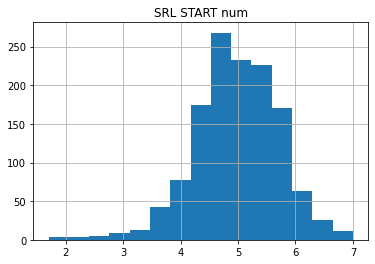

In [1547]:
MOOC3.hist(column='SRL START num', bins=15)

array([[<AxesSubplot:title={'center':'Outro SRL'}>]], dtype=object)

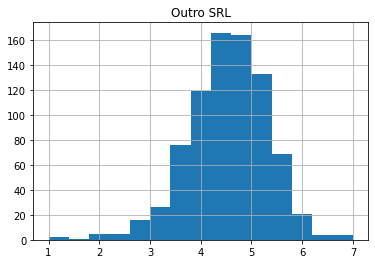

In [1548]:
MOOC3.hist(column='Outro SRL', bins=15)

array([[<AxesSubplot:title={'center':'SRL START num'}>]], dtype=object)

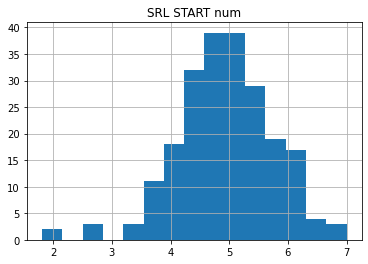

In [1549]:
MOOC4.hist(column='SRL START num', bins=15)

array([[<AxesSubplot:title={'center':'Outro SRL'}>]], dtype=object)

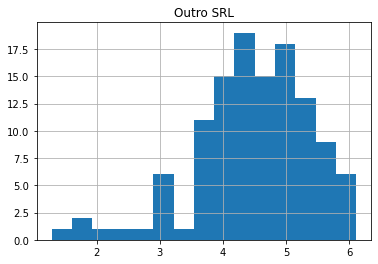

In [1550]:
MOOC4.hist(column='Outro SRL', bins=15)

### Explore with paired t-test  whether the two means of two related samples ( Into SRL και Outro SRL) are significantly different. 
Η0 : μ 1 =μ 2
Ηa : μ 1 ≠μ 2

In [1551]:
# Normality/Variance criteria
stat, p=stats.kstest(df['SRL START num'], 'norm')
print('SRL START num')
print('Kolmogorov-Smirnov test = %.4f, p = %.4f' % (stat, p))
#st.kstest(x, 'norm')
if (p > 0.05):
  print('p > 0.05: the null hypothesis that the data are normally distributed is not rejected')
else:
  print('p <= 0.05: the null hypothesis that the data are normally distributed is rejected')

SRL START num
Kolmogorov-Smirnov test = 0.9889, p = 0.0000
p <= 0.05: the null hypothesis that the data are normally distributed is rejected


In [1552]:
stats.levene(df['SRL START num'], df['Outro SRL'])

LeveneResult(statistic=nan, pvalue=nan)

### Normality criterion is violated - Therefore, we'll run Wilcoxon signed-rank test

In [1553]:
# Carrying out the Wilcoxon test
from scipy.stats import wilcoxon
d = df['Outro SRL'] - df['SRL START num']
value, p = stats.wilcoxon(d)
value, p

(69954.0, 4.266284236904034e-198)

In [1554]:
if (p > 0.05): 
  print('p > 0.05: the null hypothesis that the two groups are sampled from populations with identical distributions is not rejected')
else: # Στατιστικά σημαντική διαφορά στις κατανομές των κλικ των δύο SRL scores
  print('p <= 0.05: the null hypothesis that the two groups are sampled from populations with identical distributions is rejected')
  print('we have statistically significant evidence at α=0.05 to show that START and END SRL scores differ')

p <= 0.05: the null hypothesis that the two groups are sampled from populations with identical distributions is rejected
we have statistically significant evidence at α=0.05 to show that START and END SRL scores differ


                           MOOC3


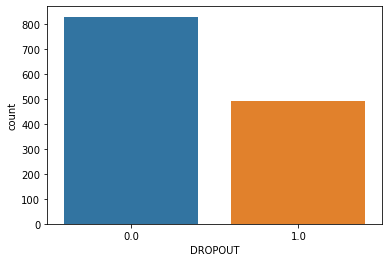

In [1555]:
plot=sn.countplot(MOOC3['DROPOUT'])
print('                           MOOC3')

# 1 DROPOUT

                           MOOC4


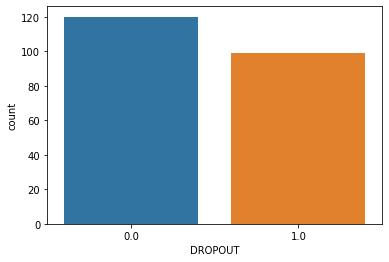

In [1556]:
plot=sn.countplot(MOOC4['DROPOUT'])
print('                           MOOC4')

# 1 DROPOUT

MOOC3 Primary goal is MOOC completion & certification (1)


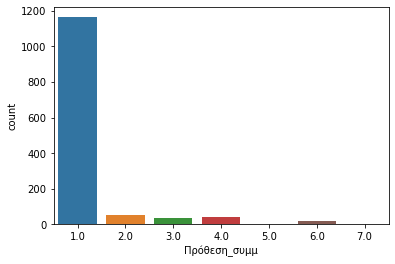

In [1557]:
plot=sn.countplot(MOOC3['Πρόθεση_συμμ'])
print('MOOC3 Primary goal is MOOC completion & certification (1)')

#1 --> Σκοπεύω να παρακολουθήσω όλο το μάθημα, να απαντήσω σε ασκήσεις-εργασίες και να πάρω και τη βεβαίωση επιτυχούς ολοκλήρωσης
#2 --> Σκοπεύω να παρακολουθήσω όλο το μάθημα, να απαντήσω σε ασκήσεις-εργασίες αλλά δεν με ενδιαφέρει αυτή τη στιγμή η βεβαίωση επιτυχούς ολοκλήρωσης
#3 --> Σκοπεύω να παρακολουθήσω το μάθημα και να απαντήσω σε ασκήσεις-εργασίες στο βαθμό που θα μπορέσω χωρίς να με ενδιαφέρει ιδιαίτερα η ολοκλήρωσή του
#4 --> Σκοπεύω να εξετάσω το υλικό του μαθήματος στην αρχή και να αποφασίσω στην πορεία αν και πόσο θα το παρακολουθήσω
#5 --> Σκοπεύω να παρακολουθήσω μόνο τα εκπαιδευτικά βίντεο του μαθήματος και δεν με ενδιαφέρουν οι ασκήσεις-εργασίες
#6 --> Έκανα εγγραφή από απλή περιέργεια για να έχω και πρόσβαση στο υλικό. Δεν γνωρίζω τώρα αν και πόσο θα παρακολουθήσω
#7 --> Τίποτε από τα παραπάνω

MOOC4 Primary goal is  MOOC completion & Certification (1)


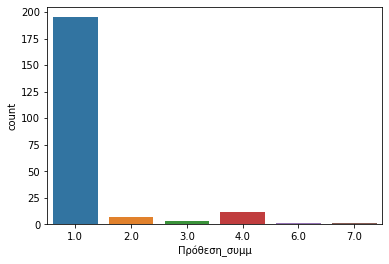

In [1558]:
plot=sn.countplot(MOOC4['Πρόθεση_συμμ'])
print('MOOC4 Primary goal is  MOOC completion & Certification (1)')

#1 --> Σκοπεύω να παρακολουθήσω όλο το μάθημα, να απαντήσω σε ασκήσεις-εργασίες και να πάρω και τη βεβαίωση επιτυχούς ολοκλήρωσης
#2 --> Σκοπεύω να παρακολουθήσω όλο το μάθημα, να απαντήσω σε ασκήσεις-εργασίες αλλά δεν με ενδιαφέρει αυτή τη στιγμή η βεβαίωση επιτυχούς ολοκλήρωσης
#3 --> Σκοπεύω να παρακολουθήσω το μάθημα και να απαντήσω σε ασκήσεις-εργασίες στο βαθμό που θα μπορέσω χωρίς να με ενδιαφέρει ιδιαίτερα η ολοκλήρωσή του
#4 --> Σκοπεύω να εξετάσω το υλικό του μαθήματος στην αρχή και να αποφασίσω στην πορεία αν και πόσο θα το παρακολουθήσω
#5 --> Σκοπεύω να παρακολουθήσω μόνο τα εκπαιδευτικά βίντεο του μαθήματος και δεν με ενδιαφέρουν οι ασκήσεις-εργασίες
#6 --> Έκανα εγγραφή από απλή περιέργεια για να έχω και πρόσβαση στο υλικό. Δεν γνωρίζω τώρα αν και πόσο θα παρακολουθήσω
#7 --> Τίποτε από τα παραπάνω

   Απασχόληση MOOC3 (Είστε εργαζόμενος; 1 Ναι, 2 Όχι)


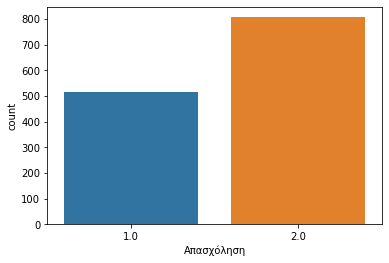

In [1559]:
plot=sn.countplot(MOOC3['Απασχόληση'])  
print('   Απασχόληση MOOC3 (Είστε εργαζόμενος; 1 Ναι, 2 Όχι)')
# 1 Ναι 2 Όχι 

   Απασχόληση MOOC4 (Είστε εργαζόμενος; 1 Ναι, 2 Όχι)


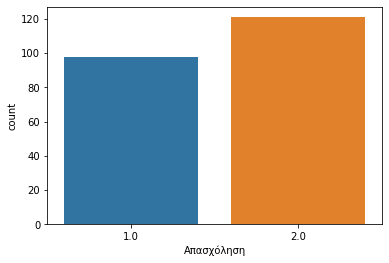

In [1560]:
plot=sn.countplot(MOOC4['Απασχόληση'])  
print('   Απασχόληση MOOC4 (Είστε εργαζόμενος; 1 Ναι, 2 Όχι)')
# 1 Ναι 2 Όχι 

                          MOOC3


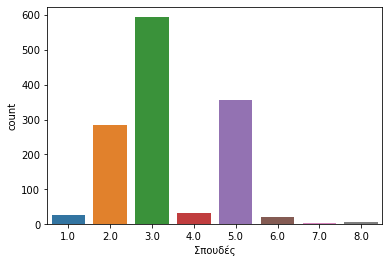

In [1561]:
plot=sn.countplot(MOOC3['Σπουδές'])   
print('                          MOOC3')
#2 --> Μεταπτυχιακό
#3 --> Πτυχίο Τριτοβάθμιας Εκπαίδευσης (Α.Ε.Ι./ Α.Τ.Ε.Ι./ Τ.Ε.Ι.)
#5 --> Απολυτήριο Λυκείου

             Οι ηλικίες των μαθητών στο MOOC3
Κλάσεις ηλικιών: 1.<17, 2.18–25, 3.26–35, 4.36–45, 5.46–55, 6.56+


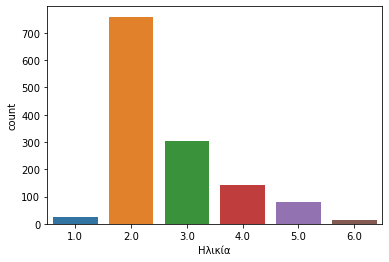

In [1562]:
plot=sn.countplot(MOOC3['Ηλικία'])   
print('             Οι ηλικίες των μαθητών στο MOOC3\nΚλάσεις ηλικιών: 1.<17, 2.18–25, 3.26–35, 4.36–45, 5.46–55, 6.56+')
#1 --> <17
#2 --> 18 – 25
#3 --> 26 – 35 
#4 --> 36 – 45
#5 --> 46 – 55 
#6 --> 56+

Text(0.5, 1.0, 'Εγκατάλειψη του MOOC3 και φύλο')

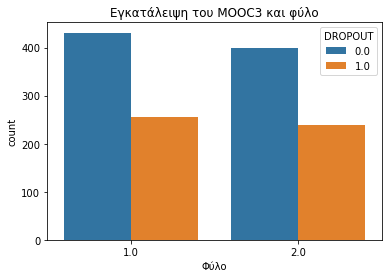

In [1563]:
sn.countplot(x='Φύλο', hue='DROPOUT', data=MOOC3)
plt.title("Εγκατάλειψη του MOOC3 και φύλο")  #1: DROPOUT
#1--> Άντρας
#2--> Γυναίκα

Text(0.5, 1.0, 'Εγκατάλειψη του MOOC3 ανά ηλικιακό group (0: Ολοκλήρωση, 1: Εγκατάλειψη)\n Κλάσεις ηλικιών: 1.<17, 2.18–25, 3.26–35, 4.36–45, 5.46–55, 6.56+\n')

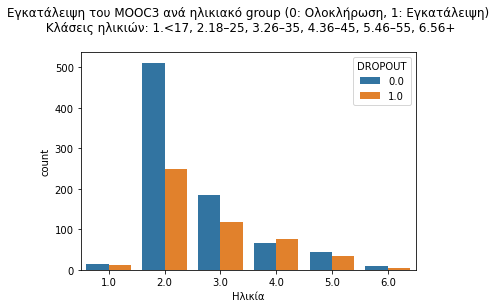

In [1564]:
sn.countplot(x='Ηλικία', hue='DROPOUT', data=MOOC3) 
plt.title("Εγκατάλειψη του MOOC3 ανά ηλικιακό group (0: Ολοκλήρωση, 1: Εγκατάλειψη)\n Κλάσεις ηλικιών: 1.<17, 2.18–25, 3.26–35, 4.36–45, 5.46–55, 6.56+\n")

Text(0.5, 1.0, 'Προφίλ SRL START categ για όσους ολοκλήρωσαν (0.0) - εγκατάλειψαν (1.0) το MOOC3\n')

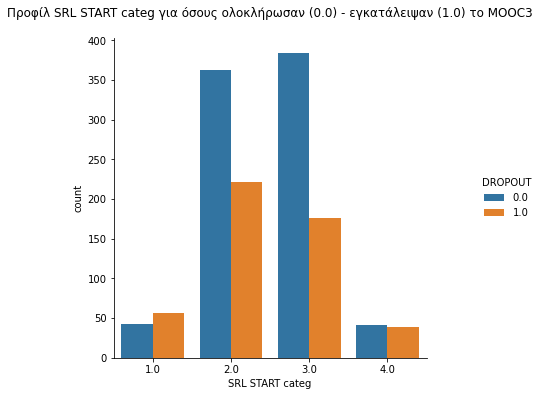

In [1565]:
sn.catplot(x='SRL START categ', hue='DROPOUT', data=MOOC3, kind="count")  
plt.title("Προφίλ SRL START categ για όσους ολοκλήρωσαν (0.0) - εγκατάλειψαν (1.0) το MOOC3\n")
#1 --> Cluster 1 <4, Καθόλου έως μικρή αυτορρύθμιση
#2 --> Cluster 2 4-5, Μέτρια αυτορρύθμιση
#3 --> Cluster 3 5-6, Καλή αυτορρύθμιση
#4 --> Cluster 4 >6, Υψηλή αυτορρύθμιση

Text(0.5, 1.0, 'Προφίλ SRL START categ για όσους ολοκλήρωσαν (0.0) - εγκατάλειψαν (1.0) το MOOC4\n')

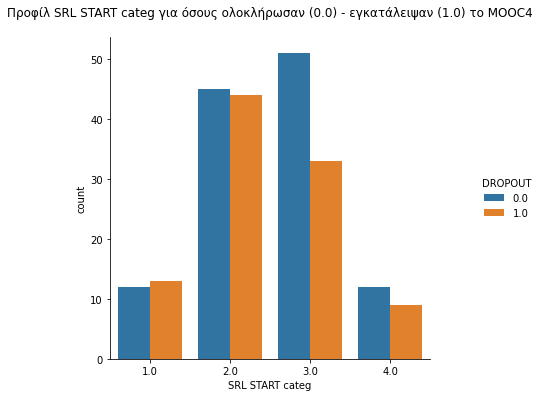

In [1566]:
sn.catplot(x='SRL START categ', hue='DROPOUT', data=MOOC4, kind="count")  
plt.title("Προφίλ SRL START categ για όσους ολοκλήρωσαν (0.0) - εγκατάλειψαν (1.0) το MOOC4\n")
#SRL Levels
#1 --> Cluster 1 <4, Καθόλου έως μικρή αυτορρύθμιση
#2 --> Cluster 2 4-5, Μέτρια αυτορρύθμιση
#3 --> Cluster 3 5-6, Καλή αυτορρύθμιση
#4 --> Cluster 4 >6, Υψηλή αυτορρύθμιση

Text(0.5, 1.0, 'Προφίλ SRL AFTER για όσους ολοκλήρωσαν (0.0) - εγκατάλειψαν (1.0) το MOOC3\n')

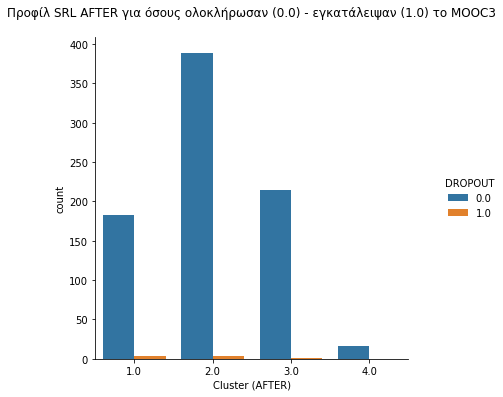

In [1567]:
sn.catplot(x='Cluster (AFTER)', hue='DROPOUT', data=MOOC3, kind="count")  
plt.title("Προφίλ SRL AFTER για όσους ολοκλήρωσαν (0.0) - εγκατάλειψαν (1.0) το MOOC3\n")

In [1568]:
MOOC3completers=MOOC3.loc[df['DROPOUT'] == 0.0]  #Keep only the completers
MOOC3completers.shape

(830, 17)

Text(0.5, 1.0, 'Αυτοαναφερόμενο προφίλ SRL στην έναρξη του MOOC\nτων μαθητών που ολοκλήρωσαν το MOOC3\n')

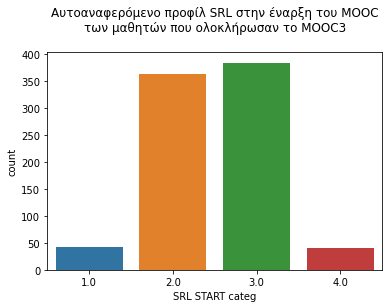

In [1569]:
sn.countplot(x='SRL START categ', data=MOOC3completers) 
plt.title("Αυτοαναφερόμενο προφίλ SRL στην έναρξη του MOOC\nτων μαθητών που ολοκλήρωσαν το MOOC3\n")

Text(0.5, 1.0, 'Αυτοαναφερόμενο προφίλ SRL στη λήξη του MOOC\nτων μαθητών που ολοκλήρωσαν το MOOC3\n')

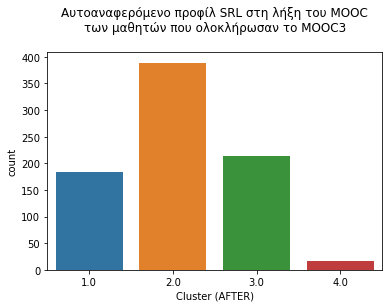

In [1570]:
sn.countplot(x='Cluster (AFTER)', data=MOOC3completers) 
plt.title("Αυτοαναφερόμενο προφίλ SRL στη λήξη του MOOC\nτων μαθητών που ολοκλήρωσαν το MOOC3\n")

In [1571]:
MOOC4completers=MOOC4.loc[df['DROPOUT'] == 0.0] 
MOOC4completers.shape

(120, 17)

Text(0.5, 1.0, 'Αυτοαναφερόμενο προφίλ SRL στην έναρξη του MOOC\nτων μαθητών που ολοκλήρωσαν το MOOC4\n')

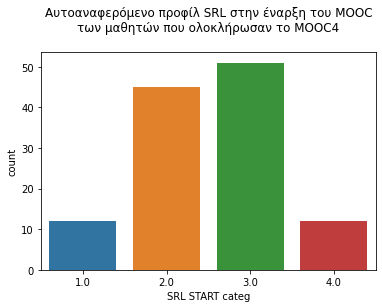

In [1572]:
sn.countplot(x='SRL START categ', data=MOOC4completers) 
plt.title("Αυτοαναφερόμενο προφίλ SRL στην έναρξη του MOOC\nτων μαθητών που ολοκλήρωσαν το MOOC4\n")

Text(0.5, 1.0, 'Αυτοαναφερόμενο προφίλ SRL στη λήξη του MOOC\nτων μαθητών που ολοκλήρωσαν το MOOC4\n')

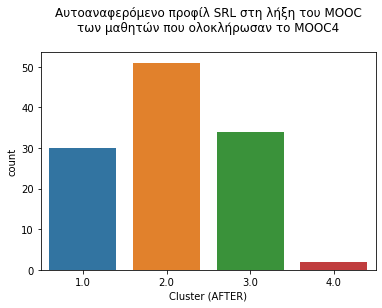

In [1573]:
sn.countplot(x='Cluster (AFTER)', data=MOOC4completers) 
plt.title("Αυτοαναφερόμενο προφίλ SRL στη λήξη του MOOC\nτων μαθητών που ολοκλήρωσαν το MOOC4\n")

Text(0.5, 1.0, 'Εγκατάλειψη του MOOC3 ανά επίπεδο εκπαίδευσης')

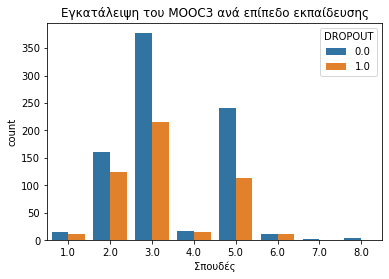

In [1574]:
sn.countplot(x='Σπουδές', hue='DROPOUT', data=MOOC3)
plt.title("Εγκατάλειψη του MOOC3 ανά επίπεδο εκπαίδευσης")
#2 --> Μεταπτυχιακό
#3 --> Πτυχίο Τριτοβάθμιας Εκπαίδευσης (Α.Ε.Ι./ Α.Τ.Ε.Ι./ Τ.Ε.Ι.)
#5 --> Απολυτήριο Λυκείου

Text(0.5, 1.0, 'SRL ανά ηλικιακό group')

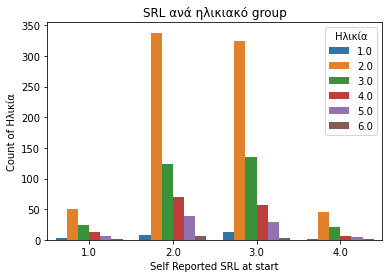

In [1575]:
sn.countplot(x='SRL START categ', hue='Ηλικία', data=MOOC3)
plt.xlabel('Self Reported SRL at start')
plt.ylabel('Count of Ηλικία')
plt.title("SRL ανά ηλικιακό group")
#1 --> <17
#2 --> 18 – 25
#3 --> 26 – 35 
#4 --> 36 – 45
#5 --> 46 – 55 
#6 --> 56+

Text(0.5, 1.0, 'Εγκατάλειψη του MOOC3 ανά ηλικιακό group (1: Dropout)')

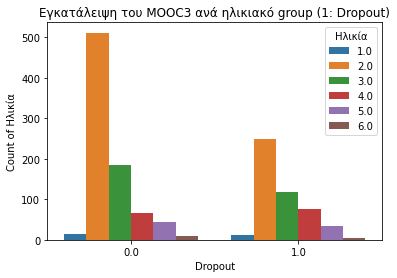

In [1576]:
sn.countplot(x='DROPOUT', hue='Ηλικία', data=MOOC3)
plt.xlabel('Dropout')
plt.ylabel('Count of Ηλικία')
plt.title("Εγκατάλειψη του MOOC3 ανά ηλικιακό group (1: Dropout)")

                          MOOC4


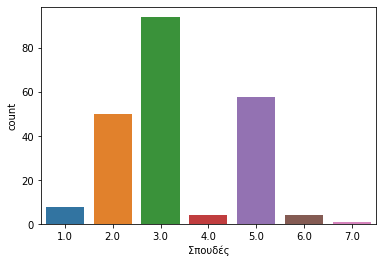

In [1577]:
plot=sn.countplot(MOOC4['Σπουδές'])   
print('                          MOOC4')

MOOC3 -  SRL at START - SRL levels: 1 Low, 4 High


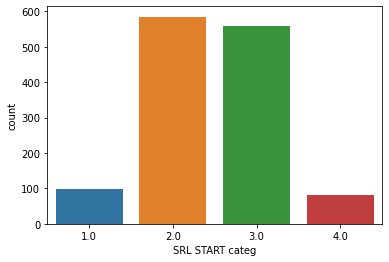

In [1578]:
plot=sn.countplot(MOOC3['SRL START categ']) 
print('MOOC3 -  SRL at START - SRL levels: 1 Low, 4 High')
#SRL Levels
#1 --> Cluster 1 <4, Καθόλου έως μικρή αυτορρύθμιση
#2 --> Cluster 2 4-5, Μέτρια αυτορρύθμιση
#3 --> Cluster 3 5-6, Καλή αυτορρύθμιση
#4 --> Cluster 4 >6, Υψηλή αυτορρύθμιση

MOOC3 - SRL at END (SRL levels: 1 Low, 4 High


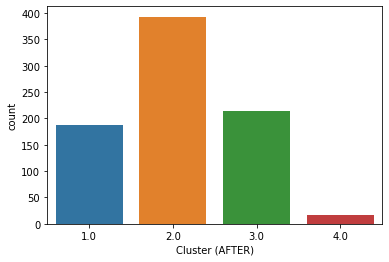

In [1579]:
plot=sn.countplot(MOOC3['Cluster (AFTER)'])
print('MOOC3 - SRL at END (SRL levels: 1 Low, 4 High')

# SRL levels (1 Low, 4 High)

                MOOC4 - SRL at START  


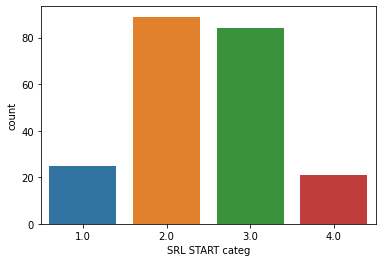

In [1580]:
plot=sn.countplot(MOOC4['SRL START categ']) 
print('                MOOC4 - SRL at START  ')

# SRL levels (1 Low, 4 High)

                MOOC4 - SRL at END  


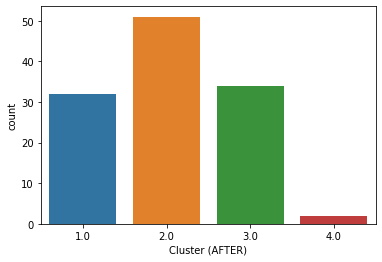

In [1581]:
plot=sn.countplot(MOOC4['Cluster (AFTER)'])
print('                MOOC4 - SRL at END  ')

In [1582]:
MOOC3_Intro_SRL_array = MOOC3['SRL START num'].to_numpy()  # Convert DataFrame Column to Numpy Array 
MOOC3_Askisi1= MOOC3['Επίδοση_Α1'].to_numpy()
MOOC3_Gender_array=MOOC3['Φύλο'].to_numpy()
MOOC3_Age_array=MOOC3['Ηλικία'].to_numpy()
MOOC3_Work_array=MOOC3['Απασχόληση'].to_numpy()
MOOC3_Educ_array=MOOC3['Σπουδές'].to_numpy()
MOOC3_Past_MOOC_Exper_array=MOOC3['Εμπειρία_MOOC'].to_numpy()
MOOC3_Past_Programming_Exper_array=MOOC3['Εμπειρία_ προγρ'].to_numpy()
MOOC3_Past_Python_Exper_array=MOOC3['Εμπειρία_ Python'].to_numpy()
MOOC3_Particip_Intention_array=MOOC3['Πρόθεση_συμμ'].to_numpy()

MOOC4_Intro_SRL_array = MOOC4['SRL START num'].to_numpy()  # Convert DataFrame Column to Numpy Array 
MOOC4_Askisi1= MOOC4['Επίδοση_Α1'].to_numpy()
MOOC4_Gender_array=MOOC4['Φύλο'].to_numpy()
MOOC4_Age_array=MOOC4['Ηλικία'].to_numpy()
MOOC4_Work_array=MOOC4['Απασχόληση'].to_numpy()
MOOC4_Educ_array=MOOC4['Σπουδές'].to_numpy()
MOOC4_Past_MOOC_Exper_array=MOOC4['Εμπειρία_MOOC'].to_numpy()
MOOC4_Past_Programming_Exper_array=MOOC4['Εμπειρία_ προγρ'].to_numpy()
MOOC4_Past_Python_Exper_array=MOOC4['Εμπειρία_ Python'].to_numpy()
MOOC4_Particip_Intention_array=MOOC4['Πρόθεση_συμμ'].to_numpy()

In [1583]:
def pre_process_df(dataset, features):
    if ('Φύλο' in features):  #Remove rows where Gender='0.0'
        dataset = dataset.loc[(dataset['Φύλο'] != 0.0)]      
    if ('Επίδοση_Α1' in features):
        dataset=dataset.dropna(subset=['Επίδοση_Α1'])
    if ('Απασχόληση' in features):  
        dataset = dataset.loc[(dataset['Απασχόληση'] != 0.0)]       
    if ('Σπουδές' in features):  
        dataset = dataset.loc[(dataset['Σπουδές'] != 0.0)]
    if ('Εμπειρία_MOOC' in features): 
        dataset = dataset.loc[(dataset['Εμπειρία_MOOC'] != 0.0)]
    if ('Πρόθεση_συμμ' in features):
        dataset = dataset.loc[(dataset['Πρόθεση_συμμ'] != 0.0)]
    return

MOOC3=MOOC3.dropna(subset=['Επίδοση_Α1'])
MOOC4=MOOC4.dropna(subset=['Επίδοση_Α1'])

### Keep only students who submitted First week's big assessment and perform some statistics

MOOC3 Dropout rates for students who submitted first weeks big assessment


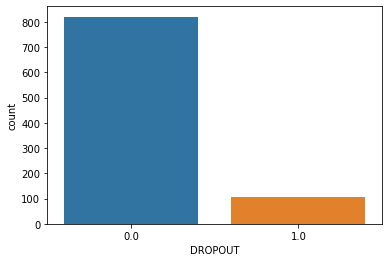

In [1584]:
# MOOC3 dropout rates for students who submitted first week's big assessment at the end of the week
plot=sn.countplot(MOOC3['DROPOUT'])
print('MOOC3 Dropout rates for students who submitted first week''s big assessment')

MOOC4 Dropout rates for students who submitted first weeks big assessment


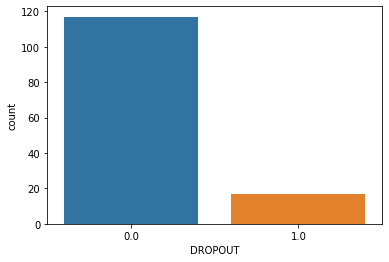

In [1585]:
# MOOC4 dropout rates for students who submitted first week's big assessment at the end of the week
plot=sn.countplot(MOOC4['DROPOUT'])
print('MOOC4 Dropout rates for students who submitted first week''s big assessment')

In [1586]:
MOOC3["DROPOUT"].value_counts()

0.0    820
1.0    107
Name: DROPOUT, dtype: int64

In [1587]:
MOOC4["DROPOUT"].value_counts()

0.0    117
1.0     17
Name: DROPOUT, dtype: int64

# # Feature selection guidance (3 techniques)

In [1588]:
features_sel=MOOC3.drop(columns=['ID','STARTED', 'Cluster (AFTER)','Subgroup', 'Outro SRL'])  

#### 1st technique: Apply SelectKBest class to extract top 10 best features

In [1589]:
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
#https://machinelearningmastery.com/feature-selection-with-categorical-data/
#https://machinelearningmastery.com/feature-selection-with-categorical-data/
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)

X=MOOC3[['Φύλο', 'Ηλικία', 'Απασχόληση', 'Επίδοση_Α1',
       'Σπουδές',
       'Εμπειρία_MOOC',
       'Εμπειρία_ προγρ',
       'Εμπειρία_ Python',
       'Πρόθεση_συμμ',
        'SRL START categ',
        ]]
y=MOOC3.iloc[:,3] # DROPOUT
fit = bestfeatures.fit(X, y)   #[features_sel],MOOC3[['DROPOUT']])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(11,'Score'))  #print 10 best features

              Specs     Score
3        Επίδοση_Α1  4.554671
8      Πρόθεση_συμμ  2.089208
5     Εμπειρία_MOOC  1.759322
7  Εμπειρία_ Python  1.430511
1            Ηλικία  1.294622
2        Απασχόληση  1.016311
9   SRL START categ  0.642582
4           Σπουδές  0.588960
0              Φύλο  0.077057
6   Εμπειρία_ προγρ  0.004450


#### 2nd technique:Use Tree model

[0.05945286 0.11308719 0.03417934 0.17547527 0.13408191 0.06494079
 0.11824704 0.08380204 0.07533006 0.14140351]


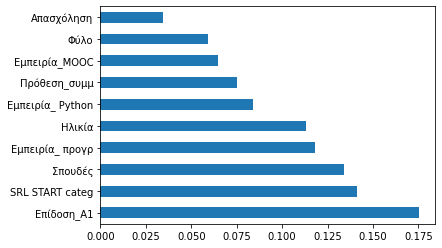

In [1590]:
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
#https://machinelearningmastery.com/feature-selection-with-categorical-data/
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

#### 3rd technique: Use Heatmap

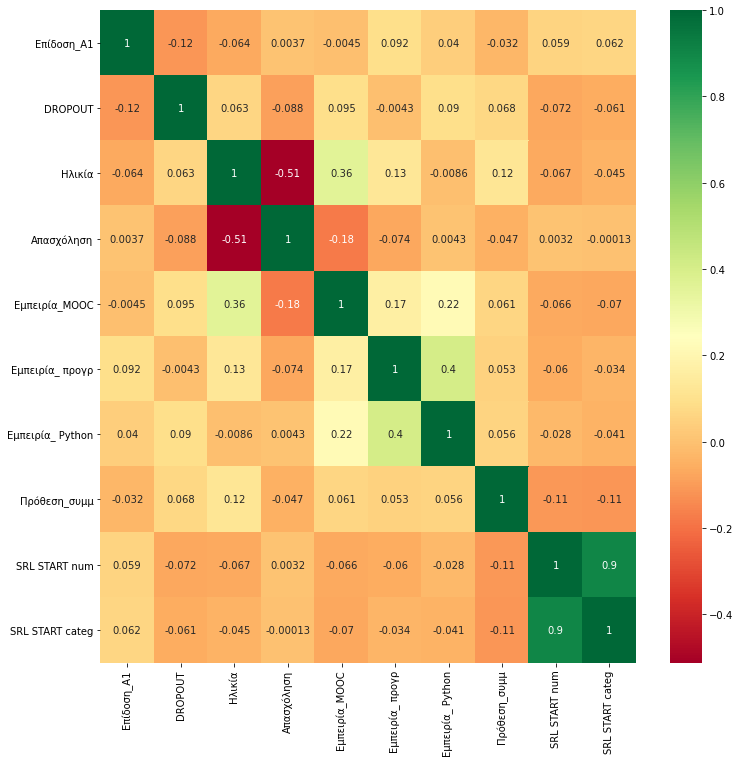

In [1591]:
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
corrmat = features_sel.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(12,12))
#plot heat map
g=sn.heatmap(features_sel[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [1592]:
#https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    return

def print_confusion_matrix(true_y, predicted_y):
    cm = confusion_matrix(true_y, predicted_y)
    print('Confusion matrix\n', cm)
    #TP, FN, FP, TN = confusion_matrix(true_y, predicted_y,labels=[1,0]).reshape(-1)
    TP1 = 0
    FP1 = 0
    TN1 = 0
    FN1 = 0
    #Just to validate that Positive=Dropped=1
    for i in range(len(predicted_y)): 
        if true_y[i]==predicted_y[i]==1: 
           TP1 += 1
        if predicted_y[i]==1 and true_y[i]!=predicted_y[i]:
           FP1 += 1
        if true_y[i]==predicted_y[i]==0:
           TN1 += 1
        if predicted_y[i]==0 and true_y[i]!=predicted_y[i]:
           FN1 += 1
    #print(confusion_matrix(true_y, predicted_y))  #,labels=[1,0]
    print('TN, FP, FN, TP : ', TN1, FP1, FN1, TP1) 
    return

#https://stackoverflow.com/questions/42562146/classification-report-with-nested-cross-validation-in-sklearn-average-individua
#https://localcoder.org/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn
#https://towardsdatascience.com/understanding-the-confusion-matrix-from-scikit-learn-c51d88929c79

def print_cv_scores(pipeline, features, label, data, a_model, bagging):
    cross_val_scores=0
    predicted_targets = np.array([])
    actual_targets = np.array([])
    #fit and evaluate in MOOC3
    for metric in ["roc_auc", "accuracy","precision", "recall",  "f1" ]: 
        cross_val_scores = cross_val_score(pipeline, features, label, scoring=metric, cv=10)
        # Fitting is implemented inside the cross_val_score function.
        #print(cross_val_scores)
        if (metric!='f1'):
            print(a_model + '\t' + data + '\tbagging: '+ bagging + '\t' + metric + ': \t{:.3f} ({:.3f})'
                  .format(mean(cross_val_scores), std(cross_val_scores)))
        else:
            print(a_model + '\t' + data + '\tbagging: '+ bagging + '\t' + metric + ': \t\t{:.3f} ({:.3f})'
                  .format(mean(cross_val_scores), std(cross_val_scores)))
    y_pred = cross_val_predict(pipeline, features, label, cv=10)
    print_confusion_matrix(label, y_pred)
    print('------------------------- Classification_report -------------------------\n')
    print(classification_report(label, y_pred))
    #Test in MOOC4. Model is alreaded fitted with MOOC3 data by using cross_val_score function
    MOOC4_y_pred = cross_val_predict(pipeline, MOOC4_features, MOOC4_label, cv=10)
    m_accuracy = accuracy_score(MOOC4_label, MOOC4_y_pred)
    m_roc_auc = roc_auc_score(MOOC4_label, MOOC4_y_pred)
    m_precision = precision_score(MOOC4_label, MOOC4_y_pred)
    m_recall = recall_score(MOOC4_label, MOOC4_y_pred)
    m_f1 = f1_score(MOOC4_label, MOOC4_y_pred)
    calc = [ m_roc_auc, m_accuracy, m_precision, m_recall,  m_f1]
    data='MOOC4'
    print('\n========================= TEST IN MOOC4 DATA  ==========================\n')
    # https://stackoverflow.com/questions/61755143/how-do-i-transfer-a-classification-machine-learning-model-from-one-data-set-to-a
    for i, metric in enumerate(metrics):          
            print(a_model + '\t' + data + '\tbagging: '+ bagging + '\t' + metric + ': \t{:.3f}'.format(calc[i]))  
    print_confusion_matrix(MOOC4_label, MOOC4_y_pred)
    print('------------------------- Classification_report -------------------------\n')
    print(classification_report(MOOC4_label, MOOC4_y_pred))
    return

pipe_NB = Pipeline([('scl', StandardScaler()),
    ('pca', PCA(0.9)), 
    ('clf', GaussianNB())])

pipe_LR = Pipeline([('scl', StandardScaler()),
    ('pca', PCA(0.9)), 
    ('clf', LogisticRegression(random_state=42, multi_class='ovr'))])  # binary Logistic Regression

pipe_SVM = Pipeline([('scl', StandardScaler()),
    ('pca', PCA(0.9)), 
    ('clf', svm.SVC(random_state=42))])  

pipe_DT = Pipeline([('scl', StandardScaler()),
    ('pca', PCA(0.9)), 
    ('clf', tree.DecisionTreeClassifier(random_state=42))])

pipe_kNN = Pipeline([('scl', StandardScaler()),
    ('pca', PCA(0.9)),
    ('clf', neighbors.KNeighborsClassifier(n_neighbors = 3))])

pipelines = [pipe_NB, pipe_LR, pipe_SVM, pipe_DT, pipe_kNN]  

pipe_dict = {0: 'Gaussian Naive Bayes', 1: 'Logistic Regression', 2: 'Support Vector Machine', 3: 'Decision Tree', 
             4: 'k Nearest Neighbours (kNN)'}

## Print prediction performance scores for selected features by using various metrics (some of them are proposed in comments)

1 Πρόθεση_συμμ
2 Επίδοση_Α1
3 Απασχόληση
4 Ηλικία
5 SRL START num
6 SRL START categ
7 Εμπειρία_ προγρ
8 Εμπειρία_MOOC
9 Εμπειρία_ Python
10 Σπουδές
11 Φύλο
Enter number of features (0 to quit): 5
Feature  1 : 1
Feature  2 : 3
Feature  3 : 4
Feature  4 : 5
Feature  5 : 8
FEATURES:
['Πρόθεση_συμμ', 'Απασχόληση', 'Ηλικία', 'SRL START num', 'Εμπειρία_MOOC']

4 PCs explain [0.43094409 0.23662826 0.18324967 0.08588008] of total variance.

Most important features on every principal component (PC):
     0              1
0  PC0         Ηλικία
1  PC1   Πρόθεση_συμμ
2  PC2  SRL START num
3  PC3  Εμπειρία_MOOC

 Visualize the data in a 2D space (only 2 PCs used)


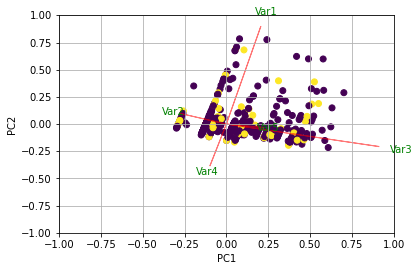

 ------ cross validation (kfold=10) ------

======================Gaussian Naive Bayes======================


=================== TRAIN AND VALIDATE IN MOOC3 DATA ===================

Gaussian Naive Bayes	MOOC3	bagging: no	roc_auc: 	0.630 (0.130)
Gaussian Naive Bayes	MOOC3	bagging: no	accuracy: 	0.845 (0.032)
Gaussian Naive Bayes	MOOC3	bagging: no	precision: 	0.231 (0.186)
Gaussian Naive Bayes	MOOC3	bagging: no	recall: 	0.161 (0.122)
Gaussian Naive Bayes	MOOC3	bagging: no	f1: 		0.186 (0.143)
Confusion matrix
 [[766  54]
 [ 90  17]]
TN, FP, FN, TP :  766 54 90 17
------------------------- Classification_report -------------------------

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91       820
         1.0       0.24      0.16      0.19       107

    accuracy                           0.84       927
   macro avg       0.57      0.55      0.55       927
weighted avg       0.82      0.84      0.83       927


========================= T

In [1593]:
all_features= [ 'Πρόθεση_συμμ', 'Επίδοση_Α1', 'Απασχόληση', 'Ηλικία', 'SRL START num', 'SRL START categ',
    'Εμπειρία_ προγρ', 'Εμπειρία_MOOC', 'Εμπειρία_ Python', 'Σπουδές', 'Φύλο']
item_count=1

for i in range(len(all_features)):
    print(i+1, all_features[i])
myfeatures=[]
n = int(input("Enter number of features (0 to quit): ")) 

import sys

if (n < 1) or (n > 12):
    sys.exit("Program Termination")
    
for i in range(1, n+1): 
    print('Feature ', i,': ', end='')
    an_element = int(input())
    myfeatures.append(all_features[an_element-1]) 
print('FEATURES:')
print(myfeatures)
pre_process_df(MOOC3, myfeatures)
pre_process_df(MOOC4, myfeatures)

metrics=[ 'roc_auc', 'accuracy', 'precision', 'recall', 'f1_score' ]

MOOC3['myfeatures_tupled'] = MOOC3[myfeatures].apply(tuple, axis=1)
MOOC4['myfeatures_tupled'] = MOOC4[myfeatures].apply(tuple, axis=1)
MOOC3_label=MOOC3['DROPOUT'].to_numpy()
MOOC3_features=list(MOOC3['myfeatures_tupled'])
MOOC4_label=MOOC4['DROPOUT'].to_numpy()
MOOC4_features=list(MOOC4['myfeatures_tupled'])
k=0
for i, pipe in enumerate(pipelines):
    pca=PCA(0.9)
    pca.fit(MOOC3_features, MOOC3_label)
    if (k==0):
        print('\n{0} PCs explain {1} of total variance.'
              .format(len(pca.explained_variance_ratio_), pca.explained_variance_ratio_))
        k+=1
        # number of PCs (principal components)
        n_pcs= pca.components_.shape[0]
        x_pc = pca.transform(MOOC3_features)
        #print(abs( pca.components_ ))
#https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis
        # get the index of the most important feature on each component
        most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
        initial_feature_names = myfeatures
        # get the names
        most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
        dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
        # build the dataframe
        features_df = pd.DataFrame(dic.items())
        print('\nMost important features on every principal component (PC):')
        print(features_df)
        #Call the function. Use only the 2 PCs.
        if len(myfeatures)>1:
            print('\n Visualize the data in a 2D space (only 2 PCs used)' )
            myplot(x_pc[:,0:2],np.transpose(pca.components_[0:2, :]))
            plt.show()
        print(' ------ cross validation (kfold=10) ------')
    print('\n======================'+pipe_dict[i]+ '======================\n')
    print('\n=================== TRAIN AND VALIDATE IN MOOC3 DATA ===================\n')
    print_cv_scores(pipe, MOOC3_features, MOOC3_label, 'MOOC3', pipe_dict[i], 'no')  # kfold=10
    print('\n================ TRAIN AND VALIDATE IN MOOC3 DATA - bagging ================\n')
    # Instantiate the bagging classifier
    bgclassifier = BaggingClassifier(base_estimator=pipe, n_estimators=100, 
                                 max_features=1.0, #len(all_features)-1,
                                 max_samples=100, random_state=1, n_jobs=5)
    print_cv_scores(bgclassifier, MOOC3_features, MOOC3_label, 'MOOC3', pipe_dict[i],'yes')  # kfold=10     